<a href="https://colab.research.google.com/github/AyHaski/DataScienceSS20Project/blob/master/DataScienceProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real or Not? NLP with Disaster Tweets
Dieses Notebook wurde für das Abschluss Projekt in Data Science für die Hochschule Offenburg erstellt. 
Kooperationspartner: Jonas Zimmer.

Kaggel ID: 5225680

Kaggel Username: ayhaski 

Beste Leaderboard Position:  275



Notebooks die geholfen haben:

https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro

https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

https://www.kaggle.com/parthplc/word2vec-tutorial



# Vorbereitung

## Package Installs

In [ ]:
#!git clone https://github.com/AyHaski/DataScienceSS20Project
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install sentencepiece
!pip install -q tf-nightly
!pip install --ignore-installed tf-nightly
!pip install plotly
!pip install xgboost 

Damit die Packages richtig verwendet werden muss die Runtime zuvor einmal neugestartet werden.

In [ ]:
#Restart runtime because of pip installs
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Imports der Packages

In [1]:
#imports
import nltk
nltk.download("popular")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from nltk.corpus import stopwords
import matplotlib as mpl
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
import tensorflow_hub as hub
import tensorflow as tf
import bert
from tensorflow.keras.models import Model
import math

mpl.style.use("seaborn")
STOP = stopwords.words('english')

In [3]:
#train = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
#test = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/test.csv', dtype={'id': np.int16})
train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
test = pd.read_csv('test.csv', dtype={'id': np.int16})

# Data Analysis

Zu Beginn werden die Train und Test Daten betrachtet, um sich einen Bild der Daten machen zu können. Dabei wird zuerst die Größe und der Zustand der Daten angeschaut

## Größe der Daten

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
print ("Train data length: ", train.shape)
print ("Test data length: ", test.shape)
print ("\n\nNull values in Train data:\n\n", train.isnull().sum())
print ("\nNull values in Test data:\n\n", test.isnull().sum())

Train data length:  (7613, 5)
Test data length:  (3263, 4)


Null values in Train data:

 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Null values in Test data:

 id             0
keyword       26
location    1105
text           0
dtype: int64


In [ ]:
dist_tweets=train[train['target']==1]
ndist_tweets=train[train['target']==0]
print ("Disaster Tweets in Train data length: ", dist_tweets.shape)
print ("No Disaster Tweets in Train data length: ", ndist_tweets.shape)
print ("\n\nNull values in disaster Tweets:\n\n", dist_tweets.isnull().sum())
print ("\nNull values in not disaster Tweets:\n\n", ndist_tweets.isnull().sum())

Disaster Tweets in Train data length:  (3271, 5)
No Disaster Tweets in Train data length:  (4342, 5)


Null values:

 id             0
keyword       42
location    1075
text           0
target         0
dtype: int64

Null values:

 id             0
keyword       19
location    1458
text           0
target         0
dtype: int64


Wie man erkennen kann sind die Spalten 'id', 'keyword', 'location' und 'text' vorhanden. Bei einem Drittel der Datensätzen exisitiert kein Einträge in der location Spalte. Auch wenn man die Trainingsdaten in disaster und nicht disaster Tweets aufteilt bleibt der Anteil an Nullwerten bei ca. einem Drittel.


## Keywords und Location

Betrachtete man die vorhanden keywords, sind die Wörter 'fatalities', 'armageddeon' und 'deluge' am meisten vorhanden. Bei den Location sind die am häufigsten vorkommenden Werte 'USA', 'New York' und ' United States'.

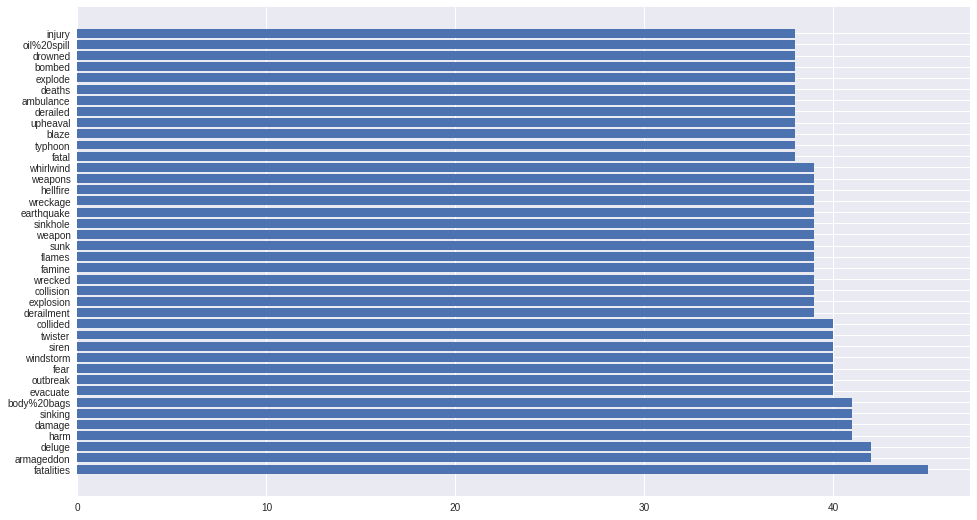

In [ ]:
keywords=train['keyword'].value_counts()
fig, ax = plt.subplots(figsize =(16, 9))

keys = list(keywords.keys()[:40]) 
values = list(keywords[:40])
# Horizontal Bar Plot 
ax.barh(keys,values) 
# Show Plot 
plt.show() 

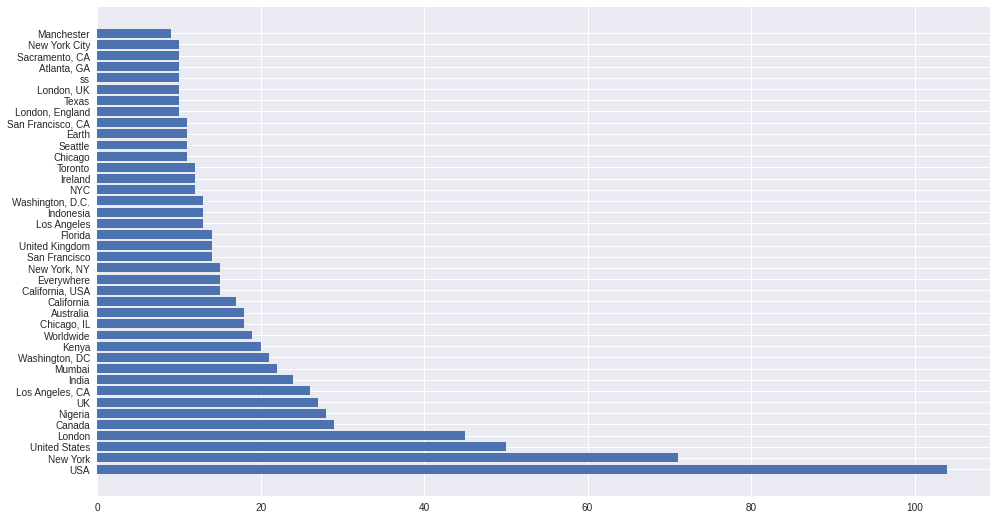

In [ ]:
locations=train['location'].value_counts()
fig, ax = plt.subplots(figsize =(16, 9))

keys = list(locations.keys()[:40]) 
values = list(locations[:40])
# Horizontal Bar Plot 
ax.barh(keys,values) 
# Show Plot 
plt.show() 

## Betrachtung der Wörter
Neben der Verteilung von Null-Werten und Disaster/Nicht Disaster Tweets wollen die einzelnen Wörter die in den jeweiligen Kateogrien vorkommen betrachtet werden, um mögliche Überschneidungen und Aufbau der einzelnen Tweets ermitteln zu können.

Distribution of diaster tweets



([<matplotlib.patches.Wedge at 0x7f1888325b00>,
 [Text(0.2411048161771122, 1.0732513534192263, 'Disaster Tweet'),
  Text(-0.24110481617711257, -1.0732513534192263, 'Not Disaster Tweet')],
 [Text(0.13151171791478847, 0.5854098291377597, '43.0%'),
  Text(-0.13151171791478866, -0.5854098291377597, '57.0%')])

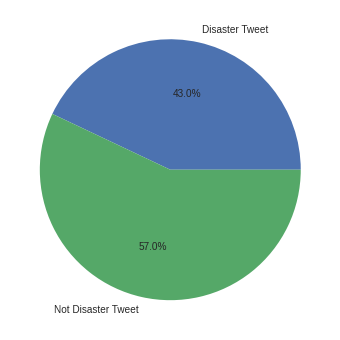

In [ ]:
print ("Distribution of disaster tweets\n")

labels = 'Disaster Tweet', 'Not Disaster Tweet'
slices = [dist_tweets['target'].size,ndist_tweets['target'].size]

fig, ax = plt.subplots(figsize=(8,6))

ax.pie(slices,labels=labels,autopct='%1.1f%%')

In [ ]:
print ("Train data which are labeld as disaster tweet: \n\n",
       dist_tweets['text'].values[:10])
print ("\n\n Train data which aren't labeld as disaster tweet: \n\n",
      ndist_tweets['text'].values[:10])

Train data which are labeld as disaster tweet: 

 ['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'
 "I'm on top of the hill and I can see a fire in the woods..."
 "There's an emergency evacuation happening now in the building across the street"
 "I'm afraid that the tornado is coming to our area..."]


 Train data which aren't labeld as disaster tweet: 

 ["What's up man?" 'I love fruits' 'Summer is lovely' 'My car is s

In [ ]:
# word_count
dist_word_count = dist_tweets['text'].apply(lambda x: len(str(x).split()))
ndist_word_count = ndist_tweets['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
dist_uword_count = dist_tweets['text'].apply(lambda x: len(set(str(x).split())))
ndist_uword_count= ndist_tweets['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
dist_sword_count = dist_tweets['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))
ndist_sword_count = ndist_tweets['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))

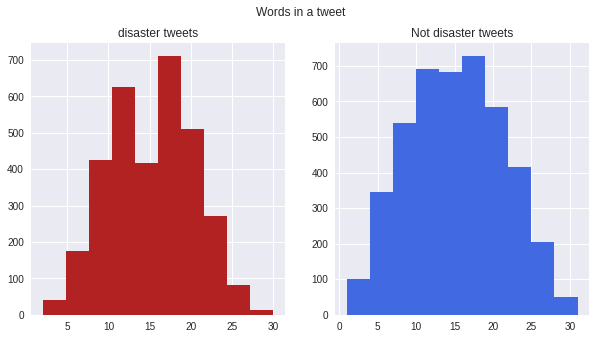

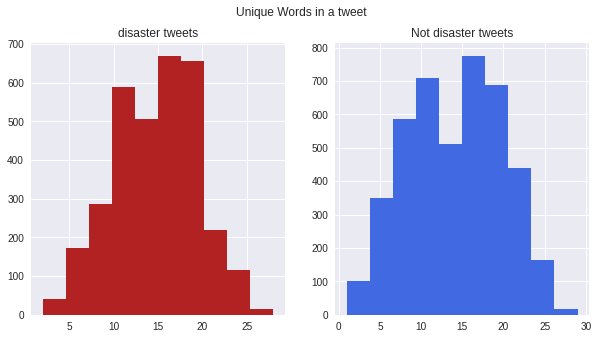

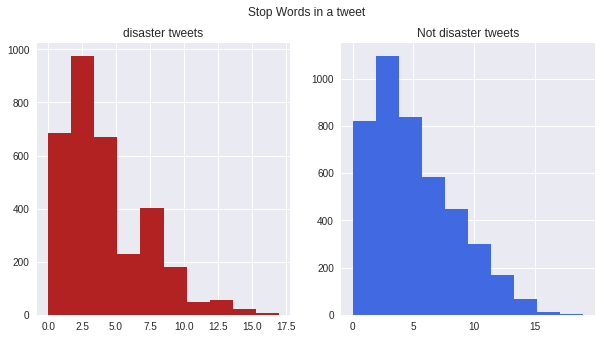

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(dist_word_count,color='firebrick')
ax1.set_title('disaster tweets')

ax2.hist(ndist_word_count,color='royalblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(dist_uword_count,color='firebrick')
ax1.set_title('disaster tweets')

ax2.hist(ndist_uword_count,color='royalblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Unique Words in a tweet')
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(dist_sword_count,color='firebrick')
ax1.set_title('disaster tweets')

ax2.hist(ndist_sword_count,color='royalblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Stop Words in a tweet')
plt.show()

Die Tweets wurden anhand der Anzahl von Wörtern insgesamt, einzigartiger Wörter und Stop Wörten verglichen. Es scheint als wären die Disaster Tweets insgesamt etwas kürzer und beinhalten weniger Stop Wörtern als Nicht Disaster Tweet. Bei der Verteilung von einzigartigen Wörtern scheinen Nicht Disaster Tweets etwas mehr Wörter zu haben.

In [ ]:
def fill_dict(dic, w):
    if w in dic:
      dic[w]+=1
    else:
      dic[w]=1

def count_words(dic, words, stopwords=0):
  for w in words:
    if stopwords:
      if w not in STOP:
        fill_dict(dic,w)
    else:
        fill_dict(dic,w)

In [ ]:
count = {}
dist_tweets['text'].apply(lambda x: count_words(count,x.lower().split(),1))
count_without_stop = sorted(count.items(), key=lambda item: item[1], reverse=True)

count = {}
ndist_tweets['text'].apply(lambda x: count_words(count,x.lower().split(),1))
count_without_stop2 = sorted(count.items(), key=lambda item: item[1], reverse=True)

In [ ]:
def plot_common_words(one,two ):
  fig,(ax1,ax2)=plt.subplots(1,2,figsize=(18,9))
  keys=[]
  values=[]  
  keys2=[]
  values2=[]
  for i in range(20):
    keys.append(one[i][0])
    values.append(one[i][1])
    keys2.append(two[i][0])
    values2.append(two[i][1])

  ax1.barh(keys,values,color='firebrick')
  ax1.set_title('Disaster Tweets')

  ax2.barh(keys2,values2,color='royalblue')
  ax2.set_title('Not Disaster Tweets')
  fig.suptitle('Common words')
  plt.show()

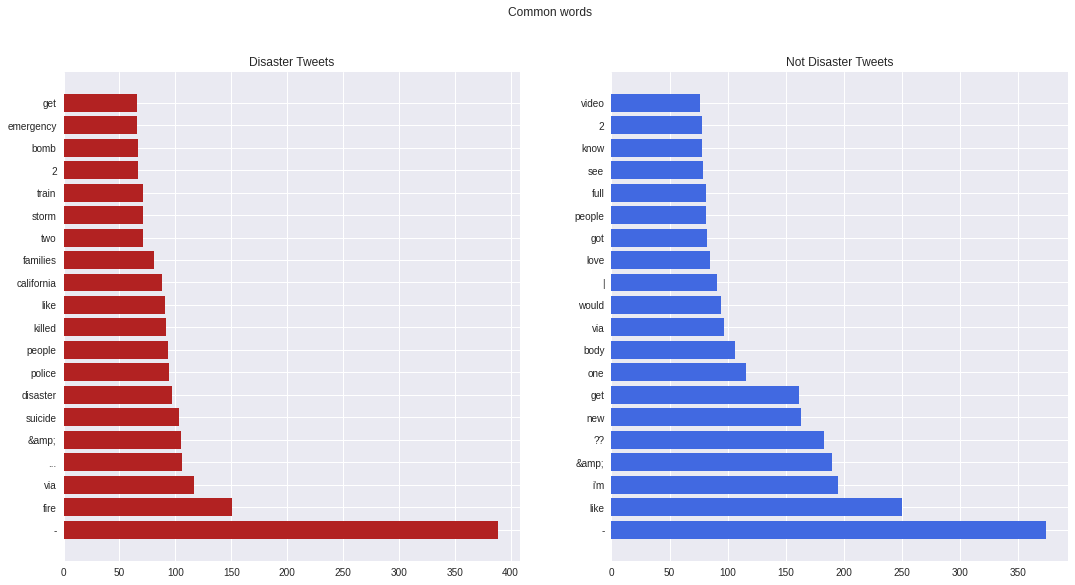

In [ ]:
plot_common_words(count_without_stop,count_without_stop2)

Schaut man sich die Häufigkeit der Wörter, ohne Stopwörter, an sieht man, dass das es einige Überschneidungen gibt. Bei beiden sind folgende Wörter bzw Charakter aufgelistet: '-', 'via', '&amp ;', 'like', '2' und 'get'. Einzelnd betrachtet kommt bei den Disaster Tweets das Word 'fire' und 'suicide' und bei den Nicht Disaster Tweets 'i'm' und 'new' am meisten vor. Insgesamt gibt es also doch relevante Überschneidungen der Tweets.

# Data Cleaning

Damit mit den Daten gearbeitet werden, kann sollten sie etwas aufgeräumt und unnötige Charaktere entfernt werden. Für das leichtere entfernen und spätere vergleichen werden alle Sätze in LowerCase umgewandelt. Danach werden Stopwörter, Links, Satz - und Sonderzeichen und Zahlen größtenteils entfernt.

In [4]:
#train = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
#test = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/test.csv', dtype={'id': np.int16})
train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
test = pd.read_csv('test.csv', dtype={'id': np.int16})

In [5]:
#Data Cleaning
#all to lower case
#remove punctiaction and other characters etc
#remove Stop words

def clean_data(x):
  x= x.lower()
  x = re.sub('https?://\S+|www\.\S+', '', x)
  x = re.sub("'", " ", x)
  x = re.sub(r"&gt;", "", x)
  x = re.sub(r"&lt;", "", x)
  x = re.sub(r"&amp;", "", x)
  x = re.sub(r"\n", " ", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"åê", "", x)
  x = re.sub(r"\x89ûï", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"\x89û", "", x)
  x = re.sub(r"\x9d", "", x)
  x = re.sub('\w*\d\w*', '', x)
  x = re.sub('ì©', 'é', x)
  x = re.sub("[@.!?\\-*#+_:,;=><'§$%&/°^`´{}>|~()]", "",x)
  return x

train['text']=train['text'].apply(lambda x: clean_data(x))
test['text']=test['text'].apply(lambda x: clean_data(x))

In [6]:
train['text'].values[:10]
test['text'].values[:10]

array(['just happened a terrible car crash',
       'heard about earthquake is different cities stay safe everyone',
       'there is a forest fire at spot pond geese are fleeing across the street i cannot save them all',
       'apocalypse lighting spokane wildfires',
       'typhoon soudelor kills  in china and taiwan',
       'we re shakingit s an earthquake',
       'they d probably still show more life than arsenal did yesterday eh eh',
       'hey how are you', 'what a nice hat', 'fuck off'], dtype=object)

In [7]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))

In [8]:
def remove_stopwords(tokens):
  toke=[]
  for t in tokens: 
    if t not in STOP:
       toke.append(t)
  return toke

train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))

Am Ende sehen die gesäuberte Daten wie folgt aus:

In [9]:
def combine_tokens(tokens):
  a=""
  for t in tokens:
    a = a + t + " "
  return a

  
train['text'] = train['text'].apply(lambda x: combine_tokens(x))
test['text'] = test['text'].apply(lambda x: combine_tokens(x))
train['text'].head()

0        deeds reason earthquake may allah forgive us 
1               forest fire near la ronge sask canada 
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

# Data Learning

Für das Vorhersagen der Testdaten wurden verschiedene Varianten eingesetzt und miteinander verglichen. Dabei wurde zuerst mit simplen Lernmodellen gearbeitet wie Logistic Regression und Naive Bayes. Dann wurden die Daten mit Word2Vec bearbeitet und nochmals mit den simpleren Modellen ausgeführt um zu sehen, ob sich das Ergebnis verbessert. Am Schluss wurde das BERT Model verwendet und dort mit unterschiedlichen Hyperparametern experimentiert.

# Learning Models
Für die Einfachkeit wurden Methoden erstellt, welcher das jeweilige Model übergeben wird und das Ergebnis dann abspeichern.
Bei der Vektorizierung der Daten wurde die Tfidf Vektorizierung verwendet.

In [10]:
# classification table
def printreport(exp, pred):
    print(pd.crosstab(exp, pred, rownames=['Actual'], colnames=['Predicted']))
    print('\n \n')
    print(classification_report(exp, pred))

In [11]:
def runSimpleModels(clf, train_values, test_values, file_name="submission.csv"):
  print ("Calculating Scores")
  scores = model_selection.cross_val_score(clf,train_values, train["target"], cv=5, scoring="f1")
  print ("Scores: ", scores)
  x, x_test, y, y_test = train_test_split(train_values, train["target"])

  print ("Fitting Model...")
  clf.fit(x,y)
  predicted = clf.predict(x_test)
  printreport(y_test, predicted)
  
  print ("Making Submission...")
  predictions = clf.predict(test_values)
  #submission = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/sample_submission.csv')
  submission = pd.read_csv('sample_submission.csv')
  submission['target']= predictions
  submission.to_csv(file_name,index=False)
  
  print ("Done!")

## Logistic Regression


In [12]:
vec = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_vec = vec.fit_transform(train['text'])
test_vec = vec.transform(test["text"])

In [13]:
clf = LogisticRegression(C=1.0)
runSimpleModels(clf, train_vec, test_vec , "submissionLogisticReg.csv")

Calculating Scores
Scores:  [0.57489879 0.49389671 0.54078827 0.44678609 0.65890779]
Fitting Model...
Predicted     0    1
Actual              
0          1001   92
1           271  540

 

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1093
           1       0.85      0.67      0.75       811

    accuracy                           0.81      1904
   macro avg       0.82      0.79      0.80      1904
weighted avg       0.82      0.81      0.80      1904

Making Submission...
Done!


Mit der Logistic Regression wurde in Kaggel ein Score von 0.79129 erreicht, was an sich nicht so schlecht ist. Es stimmt mit der berechneten Accuracy überein. 

## Naive Bayes

In [14]:
vec = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_vec = vec.fit_transform(train['text'])
test_vec = vec.transform(test["text"])

In [15]:
clf = MultinomialNB()
runSimpleModels(clf, train_vec, test_vec ,"submissionNaiveBayes.csv")

Calculating Scores
Scores:  [0.57847976 0.56338028 0.60173913 0.58464385 0.72347267]
Fitting Model...
Predicted    0    1
Actual             
0          993   87
1          283  541

 

              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1080
           1       0.86      0.66      0.75       824

    accuracy                           0.81      1904
   macro avg       0.82      0.79      0.79      1904
weighted avg       0.81      0.81      0.80      1904

Making Submission...
Done!


Naive Bayes bringt einen Score von 0.79436 in Kaggle, womit es etwas besser als Logistic Regression ist, allerdings nicht wirklich signifikant. Insgesamt liefern beide Model recht ähnliche Ergebnisse, wobei der F1-Score bei ca 0.8 liegt.

## Word2Vec


Jetzt wollen wir betrachten, ob druch die Vektorizierung mit Word2Vec möglicherweise die Ergebnisse verbessert werden können.
Für die Verwendung von Word2Vec wurden vortrainierte Vektoren unter folgenden Link verwendet.

https://www.kaggle.com/umbertogriffo/googles-trained-word2vec-model-in-python


In [ ]:
import gensim
#path ="drive/My Drive/GoogleNews-vectors-negative300.bin"
path ="GoogleNews-vectors-negative300.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(path,binary=True)

In [ ]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

corpus_train = [tokenizer.tokenize(x) for x in train['text'].values]
corpus_test = [tokenizer.tokenize(x) for x in test['text'].values]

In [ ]:
def word_average(sent):
        mean = []
        for word in sent:
            if word in model.vocab:
                mean.append(model.get_vector(word))

        if not mean:  # empty words
            return np.zeros(model.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean


In [ ]:
vector_train = np.vstack([word_average(sent) for sent in corpus_train])
vector_test = np.vstack([word_average(sent) for sent in corpus_test])
print ("Train Shape: ", vector_train.shape)
print ("Test Shape: ", vector_test.shape)

(3263, 300)

In [ ]:
clf = LogisticRegression(C=1.0)
runSimpleModels(clf,vector_train, vector_test, 'submissionWord2VecLogReg.csv')

Scores:  [0.67615063 0.70477682 0.7218845  0.71510204 0.77117385]
Fitting Model...
Predicted    0    1
Actual             
0          903  177
1          250  574

 

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1080
           1       0.76      0.70      0.73       824

    accuracy                           0.78      1904
   macro avg       0.77      0.77      0.77      1904
weighted avg       0.78      0.78      0.77      1904

Making Submission...
Done!


Erstaunlicherweise verschlechtert sich der Score durch die Verwendung von Word2Vec. Der Kaggel Score liegt nun bei 0.78915. Dies kann möglicherweise daran liegen, dass der vortrainierte Vektore auf längere Texte trainiert ist und deswegen bei den Tweets die nur aus 1 bis 2 Sätzen bestehen, nicht gut vorhersagen kann.

Leider funktionierte Naive Bayes nicht, da anscheinden negative Werte berechnet wurden und so es zu einer Exception kam. Deswegen wurde stattdessen noch XGBoost verwendet.

In [ ]:
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
runSimpleModels(clf_xgb,vector_train, vector_test, 'submissionWord2VecXGB.csv')

Scores:  [0.71064204 0.66938111 0.71843137 0.72343877 0.77233877]
Fitting Model...
Predicted    0    1
Actual             
0          944  133
1          250  577

 

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1077
           1       0.81      0.70      0.75       827

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904

Making Submission...
Done!


Auch hier liefert das Model nur einen Kaggel Score von 0.79252. Somit lohnt sich die Verwendung von Word2Vec nicht. Von den simpleren Modellen lieferte Naive Bayes den besten Score.

## BERT Model

Zu Schluss soll noch das BERT Model verwendet werden, welches das aufwändigster der Modelle ist. Dabei wurde eine Neuronals Netz aufgebaut und ein vortrainiertes Model verwendet.

In [18]:
max_seq_length = 160  
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
clf_output = sequence_output[:, 0, :]

x = tf.keras.layers.Dropout(0.1)(clf_output)
out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#out = tf.keras.layers.Dense(1, activation='sigmoid')(clf_output)

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [19]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [20]:
# from https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#7.-Model
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [21]:
train_input = bert_encode(train.text.values, tokenizer, max_len=max_seq_length)
test_input = bert_encode(test.text.values, tokenizer, max_len=max_seq_length)
train_labels = train.target.values

In [22]:
checkpoint =  tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=0.0000005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history=model.fit(
    train_input, train_labels,
    validation_split=0.2,
    callbacks=[checkpoint],
    epochs=5,
    batch_size=32
)

Epoch 1/5
191/191 [==============================] - 138s 720ms/step - loss: 0.7180 - accuracy: 0.5044 - val_loss: 0.5987 - val_accuracy: 0.7282
Epoch 2/5
191/191 [==============================] - 123s 646ms/step - loss: 0.5708 - accuracy: 0.7302 - val_loss: 0.4968 - val_accuracy: 0.7781
Epoch 3/5
191/191 [==============================] - 123s 646ms/step - loss: 0.4849 - accuracy: 0.7833 - val_loss: 0.4655 - val_accuracy: 0.7945
Epoch 4/5
191/191 [==============================] - 123s 646ms/step - loss: 0.4493 - accuracy: 0.8036 - val_loss: 0.4517 - val_accuracy: 0.8050
Epoch 5/5
191/191 [==============================] - 123s 646ms/step - loss: 0.4047 - accuracy: 0.8270 - val_loss: 0.4447 - val_accuracy: 0.8089


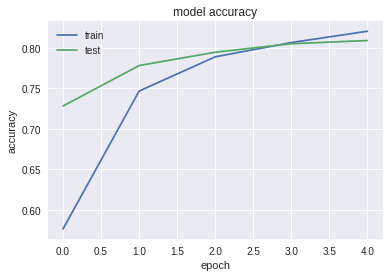

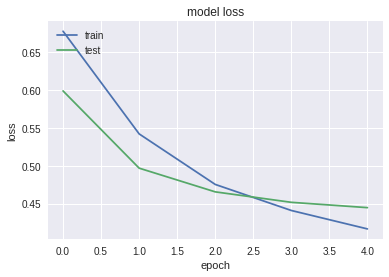

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
#submission = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/sample_submission.csv')
submission = pd.read_csv('sample_submission.csv')

In [25]:
model.trainable=False

optimizer = tf.keras.optimizers.Adam(lr=0.0000005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.load_weights('model.h5')
train_pred = model.predict(test_input)


In [26]:
submission['target'] = train_pred.round().astype(int)
submission.to_csv('submissionBert.csv', index=False)

Das erste Model von Bert lieferte mit folgenden Hyperparametern einen Score von 0.80968
* 3 Epochen
* Validation Split 0.3
* Batchsize 32
* learning_rate 0.00001
* ohne Dropout

Damit war das Model jetzt schon besser als die simpleren Modelle. Allerdings zeigten die Kurven, dass das Model wahrscheinlich Overfitted, da sich bei den Trainingsdaten der Loss verringerte und die Accuracy steigt aber bei den Test daten die Accuracy nach der 1sten Epoche bereits wieder schlechter wird und der Loss steigt.

Aus diesem Grund wurde Dropout eingebaut, um das Ergebniss nochmals zu verbessern.

Das Model wurde dreimal mit folgende Hyperparametern ausgeführt und dreimal bei Kaggel eingreicht, welche folgende Scores erreichten: 0.81887 / 0.82653 / 0,82929

* 5 Epochen
* Validation Split 0.2
* Batchsize 32
* learning_rate 0.00001
* Mit Dropout 0,1

Hier wurde bereits der Beste Score in den Versuche erreicht mit einem Kaggel Platz bei 275. Es wurde danach noch probiert an den Hyperparamtern zu experimentieren allerdings lieferten alle nur schlechtere Ergebnisse.

Kaggel Score von 0.81918 bei:

* 5 Epochen
* Validation Split 0.2
* Batchsize 32
* learning_rate 0.00001
* Mit Dropout 0,3

Kaggel Score von 0.81765 bei:

* 5 Epochen
* Validation Split 0.2
* Batchsize 32
* learning_rate 0.000001
* Mit Dropout 0,1

Kaggel Score von 0.81550 bei:

* 10 Epochen
* Validation Split 0.2
* Batchsize 32
* learning_rate 0.0000005
* Mit Dropout 0,1

Alle Scores liegen dabei recht eng beisammen, so dass man nicht definitiv sagen kann, dass die Änderungen der Hyperparamter einen großen Einfluss auf das Endergebniss hatten. So ist durchaus möglich das der Beste erreichte Score von 0.82929 durch etwas Glück erreicht worden ist.

Insgesamt wurden die besten Ergebnisse mit BERT erreicht. Der Unterschied zwischen BERT und den simpleren Modellen ist allerdings nicht sonderlich groß, da der beste Score mit Naive Bayes von 0.79436 nur ca. 0.03 vom besten BERT Score entfernt ist